# Titanic Comprehensive Analysis
**Workflow**: `dev_data_analyst.md` 적용

## 1단계: 분석 환경 및 목표 정의 (Environment & Goal)
*   **Goal**: 타이타닉 생존자 데이터(`titanic_train.csv`)를 분석하여 생존율을 예측하는 모델을 구축합니다.
*   **Models**: 
    1.  Decision Tree (의사결정나무)
    2.  Random Forest (랜덤 포레스트)
    3.  Logistic Regression (로지스틱 회귀)
*   **Methods**:
    *   K-Fold Cross Validation
    *   cross_val_score
    *   GridSearchCV (Hyperparameter Tuning for DT/RF)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 모델 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

print("All libraries imported.")

All libraries imported.


## 2단계: 데이터 적재 및 전처리 (Obtain & Scrub)
데이터를 로드하고 결측치 처리(Null Handling)와 인코딩(Encoding)을 수행합니다.

In [2]:
# 데이터 로드
df_titanic = pd.read_csv('titanic_train.csv')
print(df_titanic.info())
df_titanic.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 2-1. 결측치 처리 (Handling Missing Values)
*   **Age**: 평균 나이로 채움.
*   **Cabin**: 'N'으로 채움 (너무 결측이 많아서 Drop 혹은 N 처리).
*   **Embarked**: 'N'으로 채움.


In [3]:
df_titanic['Age'].fillna(df_titanic['Age'].mean(), inplace=True)
df_titanic['Cabin'].fillna('N', inplace=True)
df_titanic['Embarked'].fillna('N', inplace=True)

print('결측치 개수:', df_titanic.isnull().sum().sum())

결측치 개수: 0


### 2-2. 불필요 컬럼 제거 & 인코딩
*   **Drop**: PassengerId, Name, Ticket (분석에 불필요)
*   **Encoding**: Sex, Embarked, Cabin(앞글자만) -> LabelEncoding


In [4]:
# 불필요 컬럼 제거
df_titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Cabin은 첫 글자만 따옴 (ex: C85 -> C)
df_titanic['Cabin'] = df_titanic['Cabin'].str[:1]

# 레이블 인코딩 함수
def encode_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

df_titanic = encode_features(df_titanic)
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,7,3


## 3단계: 탐색적 데이터 분석 (Explore - EDA)
간단하게 주요 변수별 생존율을 시각화합니다.

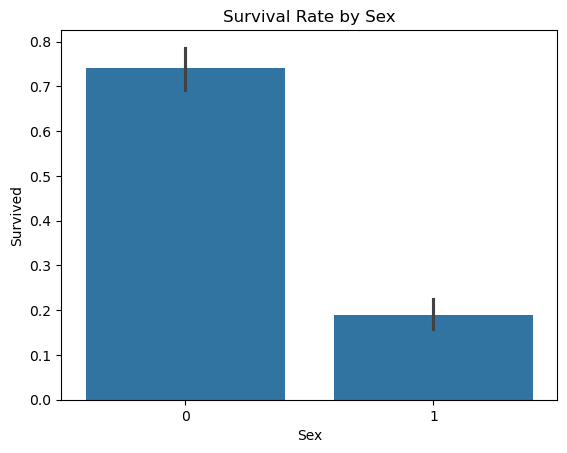

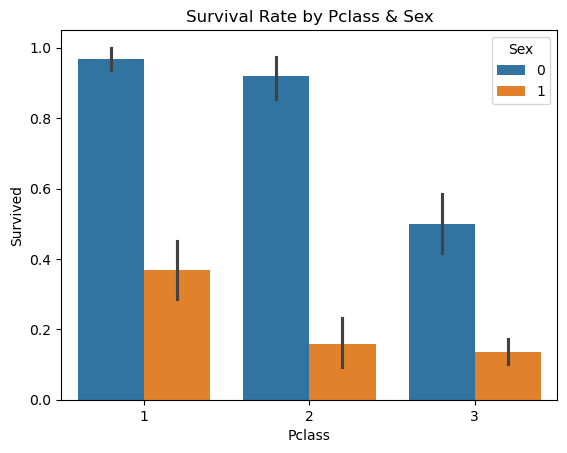

In [5]:
# 성별에 따른 생존율
sns.barplot(x='Sex', y='Survived', data=df_titanic)
plt.title('Survival Rate by Sex') # 0: Female, 1: Male (LabelEncoded)
plt.show()

# 선실 등급(Pclass)에 따른 생존율
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df_titanic)
plt.title('Survival Rate by Pclass & Sex')
plt.show()

## 4단계: 머신러닝 모델링 (Model & Optimize)
3가지 모델(DT, RF, LR)을 비교하고 교차 검증 및 튜닝을 수행합니다.

In [6]:
# 피처와 레이블 분리
y_titanic = df_titanic['Survived']
X_titanic = df_titanic.drop('Survived', axis=1)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=11)

# 모델 객체 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear') # 작은 데이터셋에 적합

# 1. 기본 학습 및 예측
for clf in [dt_clf, rf_clf, lr_clf]:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    class_name = clf.__class__.__name__
    print(f'{class_name} 정확도: {accuracy_score(y_test, pred):.4f}')

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8659


### 4-1. K-Fold 교차 검증 (Manual Loop)
Decision Tree에 대해 5-Fold 교차 검증을 직접 수행해봅니다.

In [7]:
def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = []
    
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic)):
        X_train_cv, X_test_cv = X_titanic.values[train_index], X_titanic.values[test_index]
        y_train_cv, y_test_cv = y_titanic.values[train_index], y_titanic.values[test_index]
        
        clf.fit(X_train_cv, y_train_cv)
        predictions = clf.predict(X_test_cv)
        accuracy = accuracy_score(y_test_cv, predictions)
        scores.append(accuracy)
        print(f"교차 검증 {iter_count} 정확도: {accuracy:.4f}")
    
    print(f"평균 정확도: {np.mean(scores):.4f}")

print("--- Decision Tree K-Fold ---")
exec_kfold(dt_clf)

--- Decision Tree K-Fold ---
교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


### 4-2. cross_val_score (API 활용)
Random Forest에 대해 `cross_val_score`를 사용하여 더 간편하게 수행합니다.

In [8]:
scores = cross_val_score(rf_clf, X_titanic, y_titanic, cv=5)
print(f"--- Random Forest Cross Val Score ---")
print(f"교차 검증 점수: {np.round(scores, 4)}")
print(f"평균 정확도: {np.mean(scores):.4f}")

--- Random Forest Cross Val Score ---
교차 검증 점수: [0.7877 0.7978 0.8483 0.764  0.8652]
평균 정확도: 0.8126


### 4-3. GridSearchCV (하이퍼파라미터 튜닝)
Decision Tree와 Random Forest의 성능을 끌어올려 봅니다.

In [9]:
# Decision Tree Tuning
parameters = {'max_depth': [2, 3, 5, 10], 'min_samples_leaf': [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print(f'GridSearchCV 최적 하이퍼 파라미터: {grid_dclf.best_params_}')
print(f'GridSearchCV 최고 정확도: {grid_dclf.best_score_:.4f}')

# 최적 모델로 테스트 데이터 평가
best_dclf = grid_dclf.best_estimator_
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print(f'테스트 세트에서의 Decision Tree 정확도: {accuracy:.4f}')

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 Decision Tree 정확도: 0.8715


## 5단계: 해석 및 리포팅 (Interpret & Report)

### 📊 Feature Importance (모델 해석)
Random Forest 또는 Decision Tree가 중요하게 생각한 피처가 무엇인지 시각화합니다.

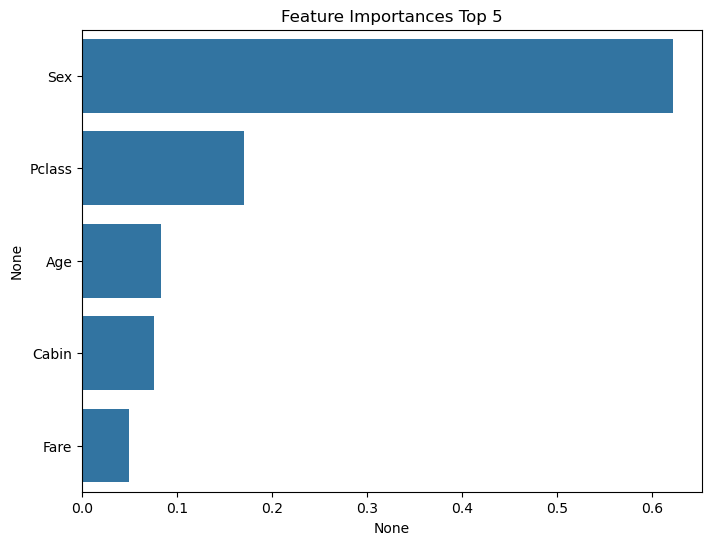

In [10]:
# 최적화된 Decision Tree의 피처 중요도
ftr_importances_values = best_dclf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

### 💡 Key Takeaways
1.  **모델 비교**: 대체로 **Random Forest**가 앙상블 기법 덕분에 Decision Tree보다 안정적인 성능을 보입니다. (Logistic Regression도 전처리가 잘되면 꽤 좋은 성능을 냅니다.)
2.  **중요 변수**: 생존 여부를 가르는 가장 결정적인 변수는 **성별(Sex)**과 **선실 등급(Pclass, Cabin)**인 것으로 보입니다. (Lady First, 상류층 우선 원칙 등을 추측 가능)
3.  **교차 검증의 힘**: 단순히 한 번 나눈 Train/Test 결과보다 교차 검증 평균 점수가 모델의 실제 실력을 더 잘 대변합니다.
